# Imports

In [1]:
import numpy as np
import random
import networkx as nx
import pandas as pd
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from sklearn.metrics import normalized_mutual_info_score
import re_mocd as remocd
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from deap import base, creator, tools, algorithms

#=========================================================================
# ~ Utils                                                                 
#=========================================================================

NUM_GRAPHS = 10
RUNS_FOR_GRAPH = 10

def communities_to_labels(communities, n_nodes):
    labels = np.zeros(n_nodes, dtype=int)
    for comm_id, comm in enumerate(communities):
        for node in comm:
            labels[node] = comm_id
    return labels

def evaluate_nmi(true_communities, detected_communities, n_nodes):
    true_labels = communities_to_labels(true_communities, n_nodes)
    detected_labels = communities_to_labels(detected_communities, n_nodes)
    return normalized_mutual_info_score(true_labels, detected_labels)

def generate_random_community_sizes(n, min_size=10, max_size=100):
    """Generates random community sizes that sum up to `n`."""
    sizes = []
    remaining = n

    while remaining > 0:
        max_valid_size = min(max_size, remaining)  # Ensure we don't exceed `n`
        
        if max_valid_size < min_size:
            # If we can't allocate at least `min_size`, merge into the last community
            sizes[-1] += remaining
            break
        
        size = random.randint(min_size, max_valid_size)
        sizes.append(size)
        remaining -= size

    return sizes

def generate_lfr_graph(n, mu=0.1, seed=10, max_retries=100):
    """Generates an LFR benchmark graph with specific community sizes."""
    
    community_sizes = generate_random_community_sizes(n)
    if sum(community_sizes) != n:
        raise ValueError("Sum of community_sizes must equal n")

    retries = 0
    G = None

    while G is None and retries < max_retries:
        try:
            partition = {}
            node_id = 0
            for i, size in enumerate(community_sizes):
                for _ in range(size):
                    partition[node_id] = i
                    node_id += 1
            
            G = nx.LFR_benchmark_graph(
                n=n, 
                tau1=3, 
                tau2=1.5, 
                mu=mu, 
                average_degree=5, 
                max_degree=50,
                min_community=min(community_sizes),
                max_community=max(community_sizes),
                seed=seed
            )
        except Exception as e:
            print(e)
            print(f"Graph generation failed, retry {retries+1}/{max_retries}")
            retries += 1

    return G


# Algorithms Definitions and functions

### MOCD Model (Shi, 2012)

In [2]:
class MocdProblem(Problem):
    def __init__(self, G):
        self.G = G
        self.n_nodes = len(G)
        self.adjacency = [list(G.neighbors(node)) + [node] for node in G.nodes()]
        n_var = self.n_nodes
        xl = np.zeros(n_var, dtype=int)
        xu = np.array([len(neighbors) - 1 for neighbors in self.adjacency], dtype=int)
        super().__init__(n_var=n_var, n_obj=2, xl=xl, xu=xu, vtype=int)

    def _evaluate(self, X, out, *args, **kwargs):
        intra = []
        inter = []
        m = self.G.number_of_edges()
        
        for chrom in X:
            H = nx.Graph()
            for node, gene in enumerate(chrom):
                neighbor = self.adjacency[int(node)][int(gene)]
                H.add_edge(node, neighbor)
            
            communities = list(nx.connected_components(H))
            comms = [set(c) for c in communities]
            intra_val = sum(sum(1 for u, v in self.G.edges(c) if v in c) for c in comms) / m
            inter_val = sum((sum(self.G.degree(u) for u in c) / (2 * m)) ** 2 for c in comms)
            
            intra.append(1 - intra_val)
            inter.append(inter_val)
        
        out["F"] = np.column_stack([intra, inter])

def max_min_selection(real_front, random_front):
    min_distances = []
    for real_sol in real_front:
        distances = [np.linalg.norm(real_sol - random_sol) for random_sol in random_front]
        min_distances.append(np.min(distances))
    return np.argmax(min_distances)

def decode_communities(chromosome, problem):
    H = nx.Graph()
    for node, gene in enumerate(chromosome):
        neighbor = problem.adjacency[int(node)][int(gene)]
        H.add_edge(node, neighbor)
    return list(nx.connected_components(H))

def run_mocd(G):
    start_time = time.time()
    problem = MocdProblem(G)
    algorithm = NSGA2(
        pop_size=100,
        sampling=IntegerRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algorithm, ('n_gen', 100), verbose=False)
    
    # Generate random graph with same degree sequence
    degrees = [d for _, d in G.degree()]
    random_G = nx.configuration_model(degrees)
    nx.relabel_nodes(random_G, {v: k for k, v in enumerate(random_G.nodes())}, copy=False)
    random_problem = MocdProblem(random_G)
    random_res = minimize(random_problem, algorithm, ('n_gen', 100), verbose=False)
    
    # Model selection
    selected_idx = max_min_selection(res.F, random_res.F)
    best_solution = res.X[selected_idx]
    communities = decode_communities(best_solution, problem)
    
    return communities, time.time() - start_time

### MOGA-Net (Pizzuti, 2009)

In [3]:
def community_score(partition, G):
    score = 0
    for community in partition:
        vS = sum(1 for i in community for j in community if G.has_edge(i, j))
        mu = [sum(1 for j in community if G.has_edge(i, j)) / len(community) for i in community]
        M_S = sum(m ** 2 for m in mu) / len(community) if len(community) > 0 else 0
        score += M_S * vS
    return score,

def community_fitness(partition, G, alpha=1):
    fitness = 0
    for community in partition:
        kin = {i: sum(1 for j in community if G.has_edge(i, j)) for i in community}
        kout = {i: sum(1 for j in G.nodes if j not in community and G.has_edge(i, j)) for i in community}
        P_S = sum(kin[i] / ((kin[i] + kout[i]) ** alpha) if (kin[i] + kout[i]) > 0 else 0 for i in community)
        fitness += P_S
    return fitness,

# Genetic Algorithm Setup
def individual_to_partition(individual, G):
    mapping = {i: individual[i] for i in range(len(individual))}
    clusters = {}
    for node, leader in mapping.items():
        clusters.setdefault(leader, set()).add(node)
    return list(clusters.values())

def evaluate(individual, G):
    partition = individual_to_partition(individual, G)
    return community_score(partition, G)[0], community_fitness(partition, G)[0]


def run_moganet(G):
    start_time = time.time()
    
    num_nodes = len(G.nodes)
    
    # Only create classes if they don't already exist.
    if not hasattr(creator, "FitnessMulti"):
        creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMulti)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_node", random.randint, 0, num_nodes - 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_node, num_nodes)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=num_nodes-1, indpb=0.2)
    toolbox.register("select", tools.selNSGA2)
    toolbox.register("evaluate", evaluate, G=G)
    
    pop = toolbox.population(n=100)
    hof = tools.ParetoFront()
    
    algorithms.eaMuPlusLambda(pop, toolbox, mu=100, lambda_=200, cxpb=0.7, mutpb=0.3, ngen=50, stats=None, halloffame=hof, verbose=False)
    
    best_partition = individual_to_partition(hof[0], G)
    elapsed_time = time.time() - start_time
    
    return best_partition, elapsed_time

### RE-MOCD

In [4]:

def run_remocd(G):
    start_time = time.time()
    community_dict = remocd.from_nx(G, debug=False)
    remocd_time = time.time() - start_time
    
    # dict -> list of sets
    community_map = {}
    for node, cid in community_dict.items():
        if cid not in community_map:
            community_map[cid] = set()
        community_map[cid].add(node)
    return list(community_map.values()), remocd_time

### Leiden/Louvain

In [5]:
def run_leiden(G):
    import leidenalg
    from igraph import Graph  
    start_time = time.time()
    
    # Convert NetworkX graph to igraph format if needed
    if not isinstance(G, Graph):
        G = Graph.from_networkx(G)  
    
    partition = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)
    leiden_time = time.time() - start_time
    return partition, leiden_time

# Running the Experiments

### Experiments Functions

In [6]:
def _run_experiment(generate_graph_func, output_filename, num_graphs, runs_per_graph):
    """
    Helper function to run experiments with varying parameters.
    
    Args:
        generate_graph_func (function): Function that generates a graph given an index.
        output_filename (str): Name of the CSV file to save results.
        num_graphs (int): Number of graphs to generate.
        runs_per_graph (int): Number of runs per graph.
    """
    # Generate all graphs first
    lfr_graphs = []
    graph_params = []
    for idx in tqdm(range(num_graphs), desc="Generating Graphs"):
        graph, n, mu = generate_graph_func(idx)
        lfr_graphs.append(graph)
        graph_params.append((n, mu))

    results = []
    
    for graph_idx in tqdm(range(num_graphs), desc="Running Experiments"):
        base_graph = lfr_graphs[graph_idx]
        n, mu = graph_params[graph_idx]
        
        # Extract ground truth communities
        true_communities = {
            frozenset(base_graph.nodes[node]["community"]) 
            for node in base_graph
        }

        graph_data = {
            "Graph": graph_idx + 1,
            "Nodes": n,
            "Edges": base_graph.number_of_edges(),
            "MU": mu,
            "Real Communities": len(true_communities),
        }

        for _ in range(runs_per_graph):
            leiden_comms, leiden_time = run_leiden(base_graph)
            mocd_comms, mocd_time = run_mocd(base_graph)
            remocd_comms, remocd_time = run_remocd(base_graph)
            moganet_comms, moganet_time = run_moganet(base_graph)

            metrics = {
                "MOCD Communities": len(mocd_comms),
                "MOCD NMI": evaluate_nmi(true_communities, mocd_comms, n),
                "MOCD Time": mocd_time,
                "REMOCD Communities": len(remocd_comms),
                "REMOCD NMI": evaluate_nmi(true_communities, remocd_comms, n),
                "REMOCD Time": remocd_time,
                "Leiden Communities": len(leiden_comms),
                "Leiden NMI": evaluate_nmi(true_communities, leiden_comms, n),
                "Leiden Time": leiden_time,
                "MogaNet Communities": len(moganet_comms),
                "MogaNet NMI": evaluate_nmi(true_communities, moganet_comms, n),
                "MogaNet Time": moganet_time,
            }

            results.append({**graph_data, **metrics})
            pd.DataFrame(results).to_csv(output_filename, index=False)

In [ ]:
def node_size_based(mu=0.5, num_nodes=10000):
    """Evaluate algorithms with increasing node sizes."""
    def graph_generator(idx):
        multiplier = idx + 1
        n = num_nodes * multiplier
        graph = generate_lfr_graph(n=n, mu=mu)
        return graph, n, mu
    
    _run_experiment(
        generate_graph_func=graph_generator,
        output_filename="results_graph_size.csv",
        num_graphs=NUM_GRAPHS,
        runs_per_graph=RUNS_FOR_GRAPH,
    )

def mu_based(num_nodes=10000, base_mu=0.1):
    """Evaluate algorithms with increasing mixing parameter."""
    def graph_generator(idx):
        mu = base_mu * (idx + 1)
        graph = generate_lfr_graph(n=num_nodes, mu=mu)
        return graph, num_nodes, mu
    
    _run_experiment(
        generate_graph_func=graph_generator,
        output_filename="results_mu_metric.csv",
        num_graphs=NUM_GRAPHS,
        runs_per_graph=RUNS_FOR_GRAPH,
    )

node_size_based()
mu_based()

Running Experiments:  30%|███       | 3/10 [5:18:52<14:14:29, 7324.27s/it]

# Plots

/tmp/ipykernel_5079/2871570219.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_nmi_melted, x='Nodes', y='NMI', hue='Algorithm',
/tmp/ipykernel_5079/2871570219.py:58: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_nmi_melted, x='MU', y='NMI', hue='Algorithm',
/tmp/ipykernel_5079/2871570219.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_time_melted, x='Nodes', y='Time', hue='Algorithm',


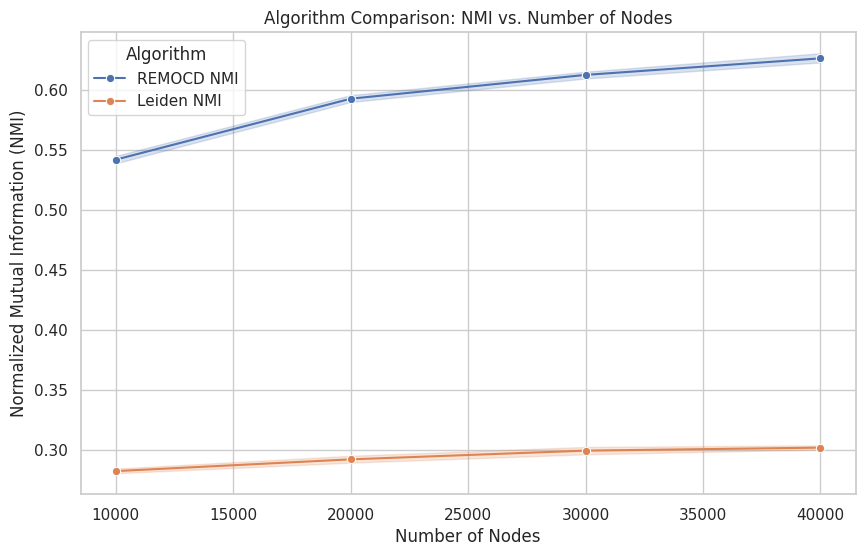

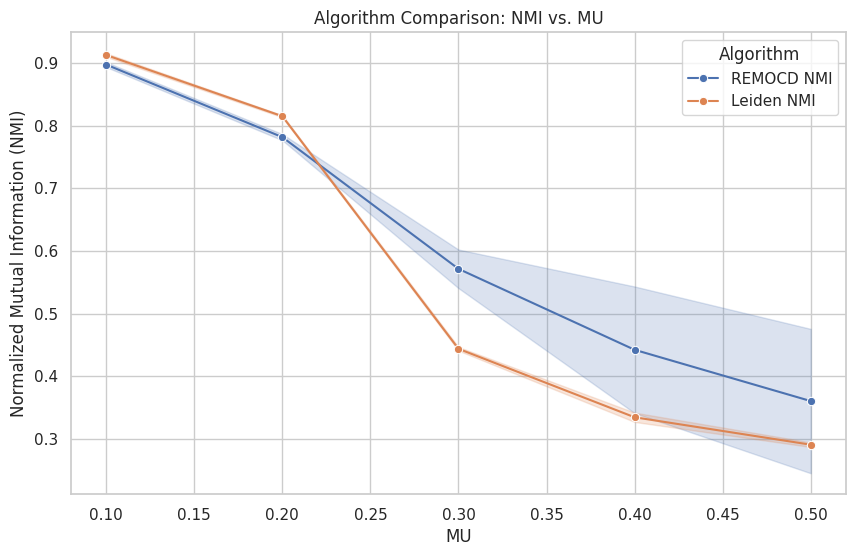

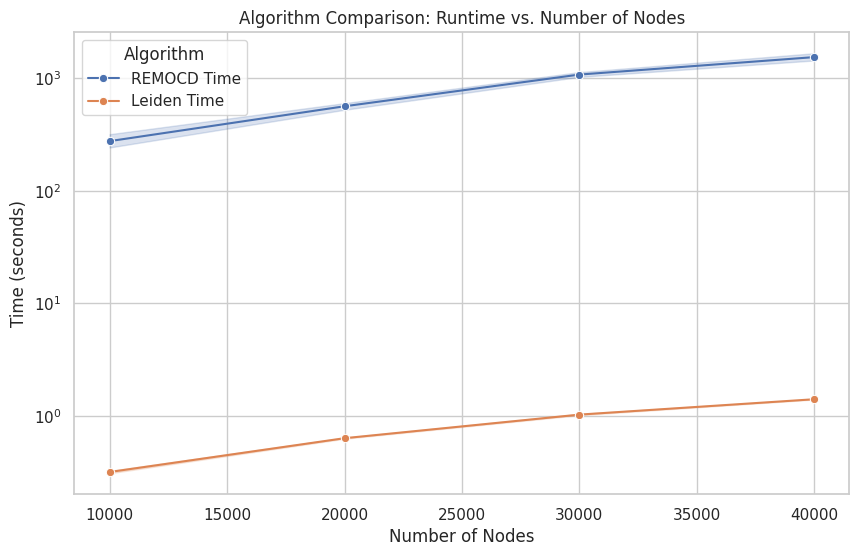

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('results_graph_size.csv')
df_mu = pd.read_csv('results_mu_metric.csv')
# ============================================================
# MU plot
# ============================================================

# Set seaborn style
sns.set(style="whitegrid")
nmi_cols = [
        'MOCD NMI', 
        'REMOCD NMI', 
        'Leiden NMI', 
        'MogaNet NMI'
        ]

# Select relevant columns and melt to long format
df_nmi = df[['Nodes'] + nmi_cols]
df_nmi_melted = pd.melt(df_nmi, id_vars=['Nodes'], 
                        value_vars=nmi_cols, 
                        var_name='Algorithm', 
                        value_name='NMI')

# Create a line plot with confidence intervals (ci=95 by default)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_nmi_melted, x='Nodes', y='NMI', hue='Algorithm',
             ci=95, marker='o')
plt.title('Algorithm Comparison: NMI vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Normalized Mutual Information (NMI)')
plt.grid(True)
plt.savefig("nmi_comparison.png")  # Save the plot if needed


#------------------------------

# Set seaborn style
sns.set(style="whitegrid")
nmi_cols = [
        'MOCD NMI', 
        'REMOCD NMI', 
        'Leiden NMI', 
        'MogaNet NMI'
        ]

# Select relevant columns and melt to long format
df_nmi = df_mu[['MU'] + nmi_cols]
df_nmi_melted = pd.melt(df_nmi, id_vars=['MU'], 
                        value_vars=nmi_cols, 
                        var_name='Algorithm', 
                        value_name='NMI')

# Create a line plot with confidence intervals (ci=95 by default)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_nmi_melted, x='MU', y='NMI', hue='Algorithm',
             ci=95, marker='o')
plt.title('Algorithm Comparison: NMI vs. MU')
plt.xlabel('MU')
plt.ylabel('Normalized Mutual Information (NMI)')
plt.grid(True)
plt.savefig("nmi_comparison.png")  # Save the plot if needed

# ----------------------------
# Plot 2: Runtime Comparisons
# ----------------------------
# Define the Time columns for each algorithm
time_cols = [
        'MOCD Time', 
        'REMOCD Time', 
        'Leiden Time', 
        'MogaNet Time'
        ]

# Select relevant columns and melt to long format
df_time = df[['Nodes'] + time_cols]
df_time_melted = pd.melt(df_time, id_vars=['Nodes'], 
                         value_vars=time_cols, 
                         var_name='Algorithm', 
                         value_name='Time')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_time_melted, x='Nodes', y='Time', hue='Algorithm',
             ci=95, marker='o')
plt.title('Algorithm Comparison: Runtime vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (seconds)')
plt.yscale("log")
plt.grid(True)
plt.savefig("time_comparison.png") 